In [1]:
import evaluation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
evaluation_data = evaluation.evaluate_all()

In [33]:
df = pd.DataFrame(evaluation_data)

In [34]:
datasets = ['aldwell', 'kostka-payne', 'reger', 'rimsky-korsakov', 'tchaikovsky', 'all_files']
evaluation_metrics = ['slice_based', 'duration_based']
models = ['random_guess', 'globalkey_guess', 'perfect_modulation', 'perfect_tonicization', 'justkeydding']

dataset_rows = []
evaluation_rows = []
model_rows = []
modulation_score_rows = []
tonicization_score_rows = []
for dataset in datasets:
    for evaluation in evaluation_metrics:
        for model in models:
            # Make a query for given parameters in modulation task
            mod = pd.DataFrame(df[
                (df.dataset == dataset) &      
                (df.evaluation == evaluation) &
                (df.model == model) &
                (df.task == 'modulation')
            ])
            mod.set_index('file', inplace=True)
            mod.rename(columns={'mirex_score': 'modulation_score'}, inplace=True)
            mod.drop(columns=['task'], inplace=True)
            # Make a query for given parameters in tonicization task
            ton = pd.DataFrame(df[
                (df.dataset == dataset) &      
                (df.evaluation == evaluation) &
                (df.model == model) &
                (df.task == 'tonicization')
            ])
            ton.set_index('file', inplace=True)
            ton.rename(columns={'mirex_score': 'tonicization_score'}, inplace=True)
            ton.drop(columns=['task'], inplace=True)
            # Put the tonicization score in the first dataframe
            mod['tonicization_score'] = ton['tonicization_score']
            # Compute additional statistics            
            dataset_rows.append(dataset)
            evaluation_rows.append(evaluation)
            model_rows.append(model)
            modulation_score_rows.append(mod.modulation_score.mean())
            tonicization_score_rows.append(mod.tonicization_score.mean())        
df_dict = {
    'dataset': dataset_rows,
    'evaluation': evaluation_rows,
    'model': model_rows,
    'modulation_mean': modulation_score_rows,
    'tonicization_mean': tonicization_score_rows
}
dfstats = pd.DataFrame(df_dict)
dfstats = dfstats[dfstats.evaluation == 'duration_based']
# print(pd.DataFrame(df_dict))

In [35]:
dfplot = pd.melt(
    dfstats, 
    id_vars=['dataset', 'model'], 
    value_vars=['modulation_mean', 'tonicization_mean'], 
    var_name='task',
    value_name='mirex_mean_score'
)
dfplot = dfplot[dfplot.dataset != "all_files"]

In [36]:
# Inject Laurent's model's results
laurent_dict = {
    'dataset': [
        'aldwell',
        'aldwell',
        'reger', 
        'reger', 
        'kostka-payne',
        'kostka-payne',
        'tchaikovsky', 
        'tchaikovsky', 
        'rimsky-korsakov',
        'rimsky-korsakov'
    ],
    'model': ['laurent'] * 10,
    'task': ['modulation_mean', 'tonicization_mean'] * 5,
    'mirex_mean_score': [
        .838, .843,
        .450, .451,
        .581, .583,
        .752, .814,
        .511, .583,
    ]    
}
df_laurent = pd.DataFrame(laurent_dict)
dfplot = pd.concat([dfplot, df_laurent])

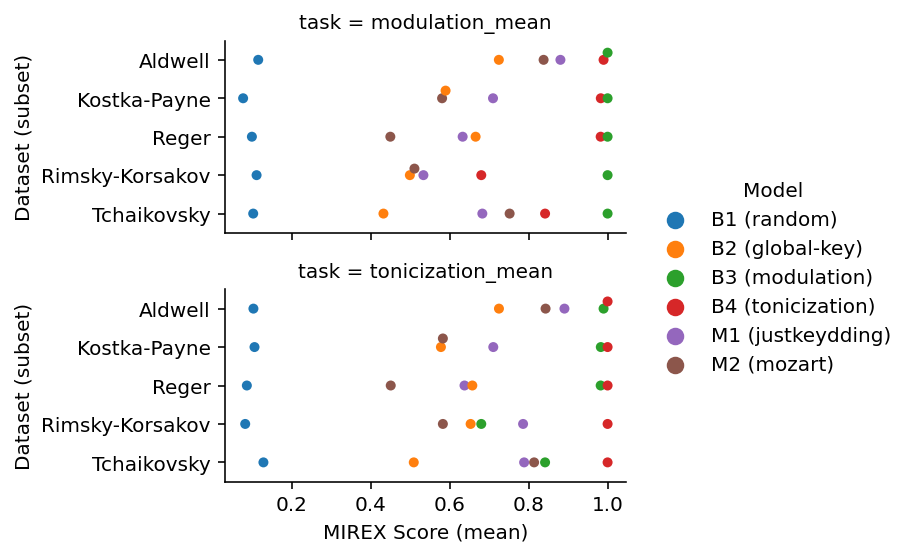

In [115]:
# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dfplot, y='model', x='mirex_mean_score', hue='task')
# sns.stripplot(data=dfplot, y='model', x='mirex_mean_score', hue='dataset')
# sns.catplot(data=dfplot, y='model', x='mirex_mean_score', row='task', kind='box')
plot = sns.catplot(
    data=dfplot, 
    y='dataset', 
    x='mirex_mean_score', 
    hue='model',    
    row='task', 
    kind='swarm',
    aspect=2.5,
    height=2,    
)
plot.set_axis_labels('MIREX Score (mean)', 'Dataset (subset)')
plot.set_yticklabels(['Aldwell', 'Kostka-Payne', 'Reger', 'Rimsky-Korsakov', 'Tchaikovsky'])
plot._legend.set_title('Model')
legend_labels = ['B1 (random)', 'B2 (global-key)', 'B3 (modulation)', 'B4 (tonicization)', 'M1 (justkeydding)', 'M2 (mozart)']
for t, l in zip(plot._legend.texts, legend_labels): t.set_text(l)